In [1]:
# import all libraries you need here
import os
import zipfile

import pandas as pd
import numpy as np

In [2]:
import scanpy as sc
import scanpy.external as sce
from scipy.stats import spearmanr
from sklearn.cluster import SpectralClustering
from sklearn import metrics

# Step 0: Download the training data

In [3]:
path_data = "."

In [4]:
# bulk_pancreas = pd.read_csv(os.path.join(path_data,"train_data","pancreas_bulk_train.csv")).set_index("level_0")
bulk_pancreas = sc.read_csv(os.path.join(path_data,"train_data","pancreas_bulk_train.csv"))

In [5]:
print(f"Number of patients in the train dataset {bulk_pancreas.shape[1]}")
print(f"Number of genes in the dataset {bulk_pancreas.shape[0]}")

Number of patients in the train dataset 4
Number of genes in the dataset 25453


In [6]:
# sc_pancreas = pd.read_csv(os.path.join(path_data,"train_data","pancreas_sc_train.csv")).set_index("Unnamed: 0")
sc_pancreas = sc.read_csv(os.path.join(path_data,"train_data","pancreas_sc_train.csv"))

In [7]:
assert bulk_pancreas.shape[0] == sc_pancreas.shape[0]
print(f"Number of cells in the train dataset {sc_pancreas.shape[1]}")

Number of cells in the train dataset 978


In [8]:
# sc_pancreas_test = pd.read_csv(os.path.join(path_data,"test_data","pancreas_sc_test.csv")).set_index("Unnamed: 0")
sc_pancreas_test = sc.read_csv(os.path.join(path_data,"test_data","pancreas_sc_test.csv"))

In [9]:
print(f"Number of cells in the test dataset {sc_pancreas_test.shape[1]}")

Number of cells in the test dataset 789


In [10]:
sc_pancreas_metadata = pd.read_csv(os.path.join(path_data,"train_data","pancreas_sc_metadata_train.csv")).set_index("Source Name")

In [11]:
for patient in sc_pancreas_metadata.Sample.unique():
    print(f"Number of cells for {patient} is {sc_pancreas_metadata[sc_pancreas_metadata.Sample==patient].shape[0]}")

Number of cells for patient1 is 249
Number of cells for patient3 is 219
Number of cells for patient2 is 234
Number of cells for patient4 is 276


In [12]:
for dis in sc_pancreas_metadata.Disease.unique():
    df = sc_pancreas_metadata[sc_pancreas_metadata.Disease==dis]
    print(f"There are {df.Sample.nunique()} train patients with {dis}")

There are 2 train patients with type II diabetes mellitus
There are 2 train patients with normal


In [13]:
print(f"There are {df.Celltype.nunique()} different cell types in the dataset")
print(f"The different cells types are {df.Celltype.unique()}")

There are 11 different cell types in the dataset
The different cells types are ['delta cell' 'alpha cell' 'beta cell' 'PSC cell' 'endothelial cell'
 'gamma cell' 'co-expression cell' 'ductal cell' 'epsilon cell'
 'unclassified endocrine cell' 'acinar cell']


In [14]:
sc_pancreas_metadata_test = pd.read_csv(os.path.join(path_data,"test_data","pancreas_sc_metadata_test_wocelltype.csv")).set_index("Source Name")

In [15]:
for patient in sc_pancreas_metadata_test.Sample.unique():
    print(f"Number of cells for {patient} is {sc_pancreas_metadata_test[sc_pancreas_metadata_test.Sample==patient].shape[0]}")

Number of cells for patient5 is 203
Number of cells for patient7 is 284
Number of cells for patient6 is 302


In [16]:
for dis in sc_pancreas_metadata_test.Disease.unique():
    df = sc_pancreas_metadata_test[sc_pancreas_metadata_test.Disease==dis]
    print(f"There are {df.Sample.nunique()} test patients with {dis}")

There are 1 test patients with normal
There are 2 test patients with type II diabetes mellitus


# Step 1: Perform the imputation

In [17]:
sc_pancreas_metadata

,Sample,Disease,Celltype
Source Name,,,
patient1_A10,patient1,type II diabetes mellitus,acinar cell
patient1_A12,patient1,type II diabetes mellitus,alpha cell
patient1_A13,patient1,type II diabetes mellitus,gamma cell
patient1_A15,patient1,type II diabetes mellitus,gamma cell
patient1_A17,patient1,type II diabetes mellitus,gamma cell
...,...,...,...
patient4_P5,patient4,type II diabetes mellitus,co-expression cell
patient4_P6,patient4,type II diabetes mellitus,alpha cell
patient4_P7,patient4,type II diabetes mellitus,alpha cell


In [18]:
sc_pancreas.to_df()

,patient1_A10,patient1_A12,patient1_A13,patient1_A15,patient1_A17,patient1_A18,patient1_A19,patient1_A20,patient1_A23,patient1_A24,...,patient4_P11,patient4_P14,patient4_P2,patient4_P3,patient4_P4,patient4_P5,patient4_P6,patient4_P7,patient4_P8,patient4_P9
SGIP1,0.0,0.0,0.0,7.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AZIN2,0.0,0.0,110.0,0.0,1.0,0.0,0.0,0.0,0.0,192.0,...,5.0,8.0,0.0,0.0,1.0,0.0,0.0,47.0,0.0,4.0
CLIC4,127.0,0.0,0.0,33.0,0.0,0.0,0.0,0.0,30.0,0.0,...,0.0,13.0,7.0,2.0,0.0,0.0,0.0,2.0,0.0,0.0
AGBL4,0.0,0.0,21.0,0.0,0.0,0.0,0.0,0.0,0.0,33.0,...,2.0,21.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
NECAP2,140.0,0.0,0.0,171.0,87.0,32.0,0.0,0.0,0.0,39.0,...,4.0,95.0,88.0,18.0,4.0,2.0,2.0,2.0,108.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
KIR2DL5B,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
KIR2DS2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
KIR2DS1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
KIR2DL2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [19]:
sc_pancreas_test.to_df()

,patient5_A12,patient5_A14,patient5_A20,patient5_A22,patient5_A4,patient5_A5,patient5_A6,patient5_B1,patient5_B12,patient5_B13,...,patient6_P18,patient6_P19,patient6_P2,patient6_P20,patient6_P21,patient6_P22,patient6_P23,patient6_P4,patient6_P7,patient6_P9
SGIP1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AZIN2,2.0,2.0,0.0,0.0,26.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,7.0,0.0,0.0,0.0,0.0,0.0,6.0
CLIC4,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,...,8.0,0.0,3.0,7.0,33.0,0.0,0.0,0.0,16.0,0.0
AGBL4,0.0,0.0,0.0,0.0,0.0,2.0,0.0,2.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,12.0,0.0,0.0,0.0
NECAP2,1.0,0.0,5.0,2.0,0.0,3.0,0.0,10.0,7.0,12.0,...,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,9.0,8.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
KIR2DL5B,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
KIR2DS2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
KIR2DS1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
KIR2DL2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [20]:
bulk_pancreas.to_df()

,patient1,patient2,patient3,patient4
SGIP1,360.0,616.0,204.0,567.0
AZIN2,388.0,344.0,434.0,405.0
CLIC4,3679.0,2753.0,4151.0,5125.0
AGBL4,118.0,155.0,209.0,137.0
NECAP2,1522.0,1737.0,1562.0,2754.0
...,...,...,...,...
KIR2DL5B,0.0,0.0,0.0,0.0
KIR2DS2,0.0,0.0,0.0,0.0
KIR2DS1,0.0,0.0,0.0,0.0
KIR2DL2,0.0,0.0,0.0,0.0


In [24]:
result = sce.pp.magic(
    sc_pancreas,
    n_pca=8,
    copy=True,
    verbose=True
)

Calculating MAGIC...
  Running MAGIC on 25453 cells and 978 genes.
  Calculating graph and diffusion operator...
    Calculating PCA...
    Calculated PCA in 0.84 seconds.
    Calculating KNN search...
    Calculated KNN search in 2.34 seconds.
    Calculating affinities...


/usr/local/lib/python3.8/dist-packages/graphtools/graphs.py:287: RuntimeWarning: Detected zero distance between 26935 pairs of samples. Consider removing duplicates to avoid errors in downstream processing.
  warnings.warn(


    Calculated affinities in 2.34 seconds.
  Calculated graph and diffusion operator in 5.55 seconds.
  Calculating imputation...


/usr/local/lib/python3.8/dist-packages/graphtools/base.py:553: RuntimeWarning: K should have a non-zero diagonal
  warnings.warn("K should have a non-zero diagonal", RuntimeWarning)


  Calculated imputation in 1.47 seconds.
Calculated MAGIC in 7.07 seconds.


/usr/local/lib/python3.8/dist-packages/magic/utils.py:145: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  data = anndata.AnnData(data)


In [25]:
result.to_df()

,patient1_A10,patient1_A12,patient1_A13,patient1_A15,patient1_A17,patient1_A18,patient1_A19,patient1_A20,patient1_A23,patient1_A24,...,patient4_P11,patient4_P14,patient4_P2,patient4_P3,patient4_P4,patient4_P5,patient4_P6,patient4_P7,patient4_P8,patient4_P9
SGIP1,1.061657,0.812941,2.579225,1.867011,0.937593,5.706148,1.646588,4.212615,1.273644,1.834297,...,0.097812,0.458970,0.962161,0.603706,0.330412,0.126573,0.082199,0.804731,1.107841,0.121788
AZIN2,8.718503,9.831376,9.814441,6.271659,7.728276,7.611186,14.247960,8.384097,7.322505,25.207134,...,1.154381,7.372228,5.550650,7.122151,1.517717,0.549040,1.268002,11.049101,22.117880,0.887177
CLIC4,68.498283,3.788935,3.564989,4.093396,3.185116,4.135774,3.583170,5.140430,5.655774,6.103114,...,0.495418,62.790340,44.952591,4.028305,1.165384,0.453446,1.077013,5.186163,16.945997,0.611127
AGBL4,1.850872,2.989146,8.680687,4.223490,4.267038,6.062180,4.363090,8.432342,3.389041,16.704910,...,0.237545,1.791136,0.665232,1.336686,0.559097,0.144875,0.214743,1.491306,4.333346,0.224286
NECAP2,70.680405,31.824265,13.451695,14.780906,12.507914,15.129021,18.102680,15.455882,23.382170,28.602259,...,3.023374,45.013485,33.598633,16.401176,3.988249,1.183881,2.977549,20.033628,65.903473,1.913790
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
KIR2DL5B,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000037,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
KIR2DS2,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000037,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
KIR2DS1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000037,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
KIR2DL2,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000037,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [26]:
train_mapping = {
    "patient1": 0,
    "patient2": 1,
    "patient3": 2,
    "patient4": 3,
}
arr = np.zeros((25453, 4))
for i in range(len(sc_pancreas_metadata.index)):
    arr[:, train_mapping[sc_pancreas_metadata.to_numpy()[i, 0]]] += result.X[:, i]


In [27]:
bulkified_train = pd.DataFrame(arr)
bulkified_train.columns = ["patient1", "patient2", "patient3", "patient4"]
print(bulkified_train)

          patient1     patient2     patient3     patient4
0       543.311411   196.622633   235.703904   241.962868
1      2972.576766   924.072880  1409.544615  2082.256061
2      2193.103888  3835.499178  2314.101394  9288.137063
3       952.678502   207.716988   363.029753   387.298894
4      5786.613050  4172.714739  2740.333941  9138.852160
...            ...          ...          ...          ...
25448     0.000000     0.000515     0.000137     0.000119
25449     0.000000     0.000515     0.000137     0.000119
25450     0.000000     0.000515     0.000137     0.000119
25451     0.000000     0.000515     0.000137     0.000119
25452     0.000000     0.000515     0.000137     0.000119

[25453 rows x 4 columns]


In [28]:
# utility function for scoring the imputation
def imputation_score(original, imputed):
    spearman_gene = []
    for g in range(imputed.shape[1]):
        if np.all(imputed[:, g] == 0):
            correlation = 0
        else:
            correlation = spearmanr(original[:, g], imputed[:, g])[0]
        spearman_gene.append(correlation)
    return np.median(np.array(spearman_gene))

imputation_score(bulk_pancreas.X, bulkified_train.to_numpy())

0.9420833338731085

0.9354507703175476 - 100\
0.938...           - 50\
0.9413606468151117 - 20\
0.9419706104794446 - 10\
0.9420796938215747 - 8

# Step 1.1: Test Data Imputation

In [29]:
# TODO use train+test for imputation, then separate them
test_result = sce.pp.magic(
    sc_pancreas_test,
    n_pca=8,
    copy=True,
    verbose=True
)

Calculating MAGIC...
  Running MAGIC on 25453 cells and 789 genes.
  Calculating graph and diffusion operator...
    Calculating PCA...
    Calculated PCA in 0.73 seconds.
    Calculating KNN search...
    Calculated KNN search in 2.21 seconds.
    Calculating affinities...


/usr/local/lib/python3.8/dist-packages/graphtools/graphs.py:287: RuntimeWarning: Detected zero distance between 33839 pairs of samples. Consider removing duplicates to avoid errors in downstream processing.
  warnings.warn(


    Calculated affinities in 2.23 seconds.
  Calculated graph and diffusion operator in 5.19 seconds.
  Calculating imputation...


/usr/local/lib/python3.8/dist-packages/graphtools/base.py:553: RuntimeWarning: K should have a non-zero diagonal
  warnings.warn("K should have a non-zero diagonal", RuntimeWarning)


  Calculated imputation in 1.21 seconds.
Calculated MAGIC in 6.45 seconds.


/usr/local/lib/python3.8/dist-packages/magic/utils.py:145: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  data = anndata.AnnData(data)


In [30]:
test_mapping = {
    "patient5": 0,
    "patient6": 1,
    "patient7": 2
}
arr = np.zeros((25453, 3))
for i in range(len(sc_pancreas_metadata_test.index)):
    arr[:, test_mapping[sc_pancreas_metadata_test.to_numpy()[i, 0]]] += test_result.X[:, i]

In [31]:
bulkified = pd.DataFrame(arr)
bulkified.insert(0, "index", bulk_pancreas.obs_names)
bulkified.columns = ["index", "patient5", "patient6", "patient7"]
print(bulkified)

          index     patient5     patient6     patient7
0         SGIP1   136.723854   659.433086   186.120736
1         AZIN2   621.530976   661.248850   315.562388
2         CLIC4   980.767113  3776.468248  4257.269531
3         AGBL4   190.960494   387.494271   141.951960
4        NECAP2  1140.123651  4453.838727  3256.290553
...         ...          ...          ...          ...
25448  KIR2DL5B     0.000397     0.000000     0.000234
25449   KIR2DS2     0.000397     0.000000     0.000234
25450   KIR2DS1     0.000397     0.000000     0.000234
25451   KIR2DL2     0.000397     0.000000     0.000234
25452   KIR2DS3     0.000397     0.000000     0.000234

[25453 rows x 4 columns]


# Step 2: Perform clustering 

In [32]:
# sc_pancreas = pd.read_csv(os.path.join(path_data,"train_data","pancreas_sc_train.csv")).set_index("Unnamed: 0")
sc_pancreas = sc.read_csv(os.path.join(path_data,"train_data","pancreas_sc_train.csv"))

In [33]:
# sc_pancreas = sc.AnnData(
#     pd.concat((sc_pancreas.T.to_df(), sc_pancreas_test.T.to_df()), axis=0),
#     pd.concat((sc_pancreas_metadata, sc_pancreas_metadata_test), axis=0)
# )
sc_pancreas = sc.AnnData(sc_pancreas.T.to_df(), sc_pancreas_metadata)

In [34]:
# normalize to depth 10 000
sc.pp.normalize_per_cell(sc_pancreas, counts_per_cell_after=1e4)

# logaritmize
sc.pp.log1p(sc_pancreas)

/usr/local/lib/python3.8/dist-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


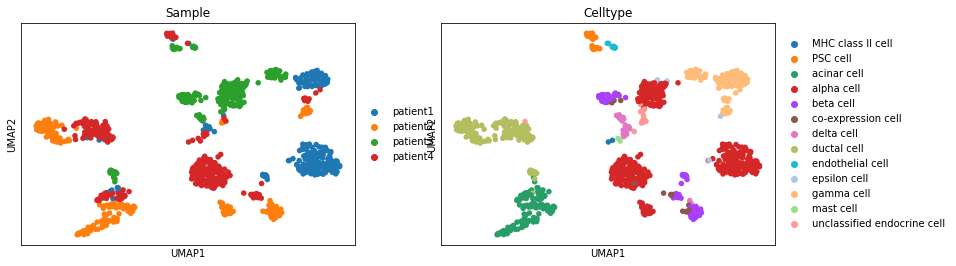

In [35]:
sc.tl.pca(sc_pancreas, n_comps=50, svd_solver='arpack')
sc.pp.neighbors(sc_pancreas)
sc.tl.umap(sc_pancreas)

sc.pl.umap(
    sc_pancreas,
    color=["Sample", "Celltype"],
    frameon=True,
)

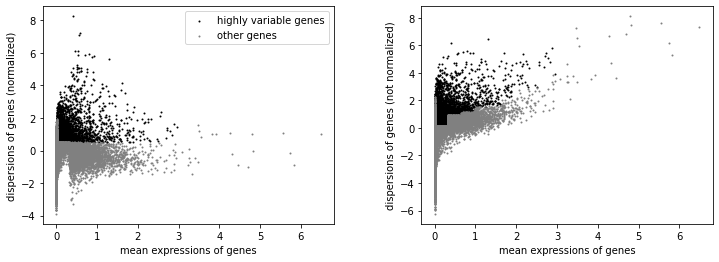

In [36]:
sc.pp.highly_variable_genes(sc_pancreas, min_mean=0.0125, max_mean=3, min_disp=0.5)
sc.pl.highly_variable_genes(sc_pancreas)

In [38]:
sc.external.pp.harmony_integrate(sc_pancreas, key="Sample", adjusted_basis="X_hm", max_iter_harmony=100, sigma=0.1)

2022-05-03 09:18:19,651 - harmonypy - INFO - Iteration 1 of 100
2022-05-03 09:18:19,762 - harmonypy - INFO - Iteration 2 of 100
2022-05-03 09:18:19,844 - harmonypy - INFO - Iteration 3 of 100
2022-05-03 09:18:19,893 - harmonypy - INFO - Iteration 4 of 100
2022-05-03 09:18:19,974 - harmonypy - INFO - Iteration 5 of 100
2022-05-03 09:18:20,030 - harmonypy - INFO - Iteration 6 of 100
2022-05-03 09:18:20,077 - harmonypy - INFO - Iteration 7 of 100
2022-05-03 09:18:20,109 - harmonypy - INFO - Iteration 8 of 100
2022-05-03 09:18:20,140 - harmonypy - INFO - Iteration 9 of 100
2022-05-03 09:18:20,177 - harmonypy - INFO - Iteration 10 of 100
2022-05-03 09:18:20,222 - harmonypy - INFO - Iteration 11 of 100
2022-05-03 09:18:20,261 - harmonypy - INFO - Iteration 12 of 100
2022-05-03 09:18:20,293 - harmonypy - INFO - Iteration 13 of 100
2022-05-03 09:18:20,339 - harmonypy - INFO - Iteration 14 of 100
2022-05-03 09:18:20,379 - harmonypy - INFO - Iteration 15 of 100
2022-05-03 09:18:20,410 - harmonyp

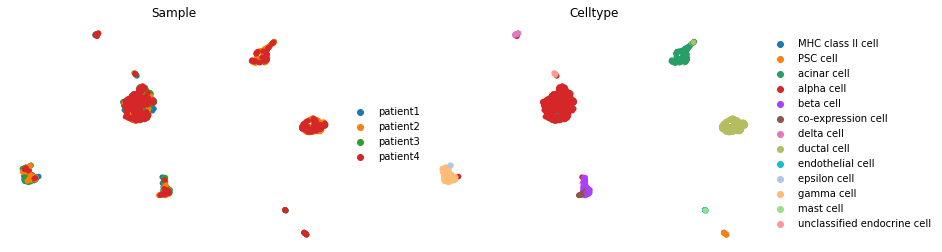

In [59]:
sc.pp.neighbors(sc_pancreas, use_rep="X_hm")
sc.tl.umap(sc_pancreas, min_dist=0.1)

sc.pl.umap(
    sc_pancreas,
    color=["Sample", "Celltype"],
    frameon=False,
)

In [60]:
def get_silhouette_score(X, cluster_labels):
    silhouette_score = metrics.silhouette_score(X, cluster_labels)
    return silhouette_score

In [61]:
def get_ari_score(true_labels, cluster_labels):
    ari_score = metrics.adjusted_rand_score(true_labels, cluster_labels)
    return ari_score

In [62]:
def get_v_score(true_labels, cluster_labels):
    v_score = metrics.v_measure_score(true_labels, cluster_labels)
    return v_score

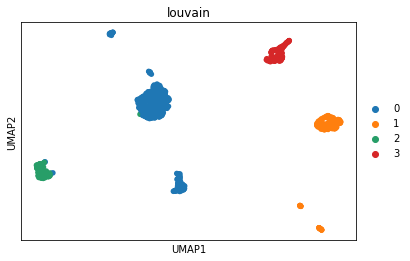

(978,)
For k = 1
The silhouette_score is : 0.20777842
The ari_score is : 0.6352373585453822
The v_score is : 0.7622070707355785
Total score is : 0.5350742844351809


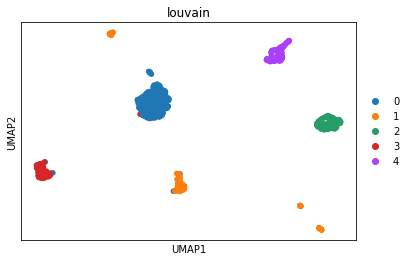

(978,)
For k = 2
The silhouette_score is : 0.2608411
The ari_score is : 0.8811200326580991
The v_score is : 0.8594837399127486
Total score is : 0.6671482913262841


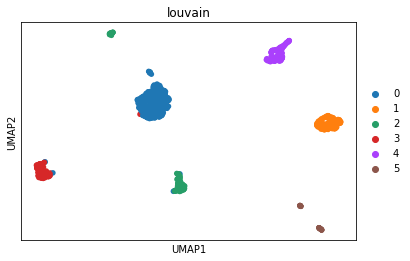

(978,)
For k = 3
The silhouette_score is : 0.29340956
The ari_score is : 0.9120914038736643
The v_score is : 0.8918895884283466
Total score is : 0.6991301828174824


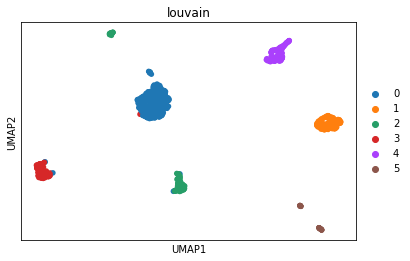

(978,)
For k = 4
The silhouette_score is : 0.29340956
The ari_score is : 0.9120914038736643
The v_score is : 0.8918895884283466
Total score is : 0.6991301828174824


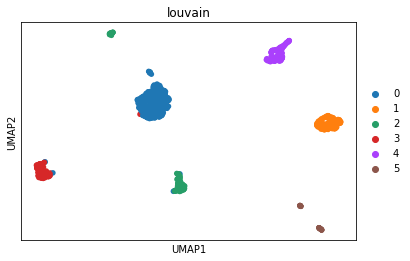

(978,)
For k = 5
The silhouette_score is : 0.29340956
The ari_score is : 0.9120914038736643
The v_score is : 0.8918895884283466
Total score is : 0.6991301828174824


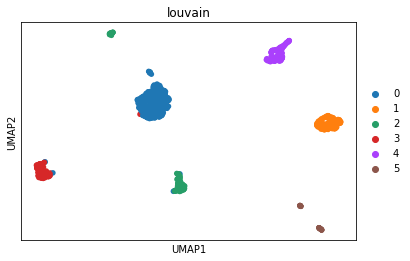

(978,)
For k = 6
The silhouette_score is : 0.29340956
The ari_score is : 0.9120914038736643
The v_score is : 0.8918895884283466
Total score is : 0.6991301828174824


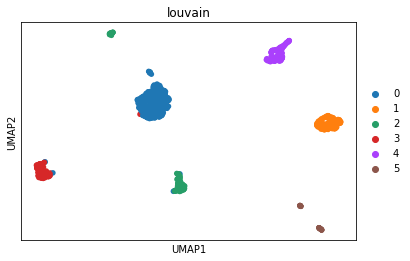

(978,)
For k = 7
The silhouette_score is : 0.29340956
The ari_score is : 0.9120914038736643
The v_score is : 0.8918895884283466
Total score is : 0.6991301828174824


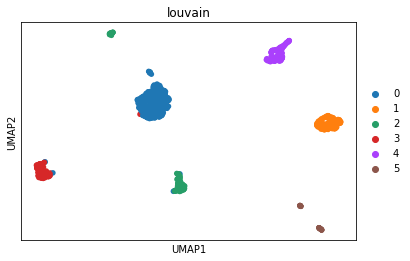

(978,)
For k = 8
The silhouette_score is : 0.29340956
The ari_score is : 0.9120914038736643
The v_score is : 0.8918895884283466
Total score is : 0.6991301828174824


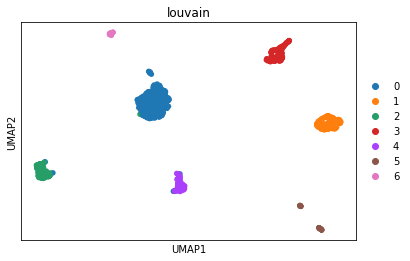

(978,)
For k = 9
The silhouette_score is : 0.3027768
The ari_score is : 0.931588610377629
The v_score is : 0.9121324087615031
Total score is : 0.7154992775487373


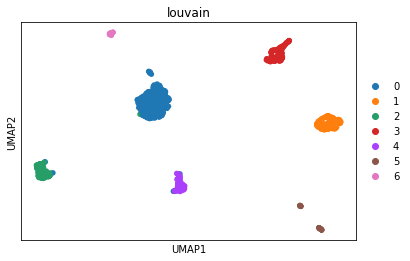

(978,)
For k = 10
The silhouette_score is : 0.3027768
The ari_score is : 0.931588610377629
The v_score is : 0.9121324087615031
Total score is : 0.7154992775487373


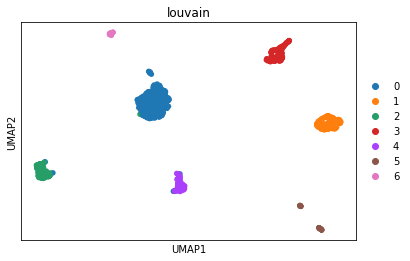

(978,)
For k = 11
The silhouette_score is : 0.3027768
The ari_score is : 0.931588610377629
The v_score is : 0.9121324087615031
Total score is : 0.7154992775487373


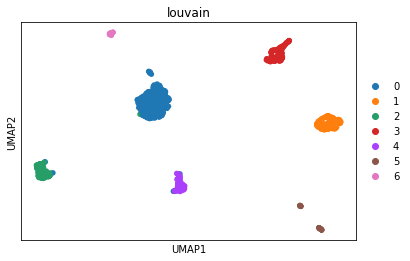

(978,)
For k = 12
The silhouette_score is : 0.3027768
The ari_score is : 0.931588610377629
The v_score is : 0.9121324087615031
Total score is : 0.7154992775487373


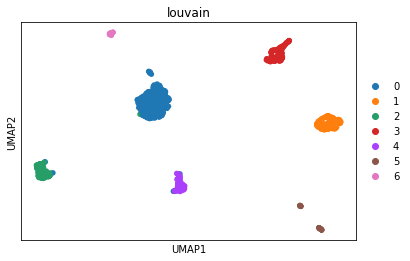

(978,)
For k = 13
The silhouette_score is : 0.3027768
The ari_score is : 0.931588610377629
The v_score is : 0.9121324087615031
Total score is : 0.7154992775487373


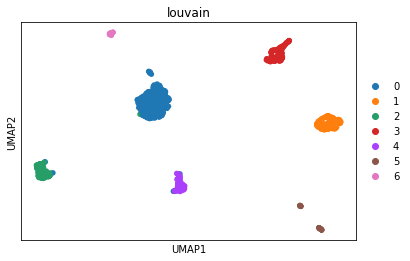

(978,)
For k = 14
The silhouette_score is : 0.3027768
The ari_score is : 0.931588610377629
The v_score is : 0.9121324087615031
Total score is : 0.7154992775487373


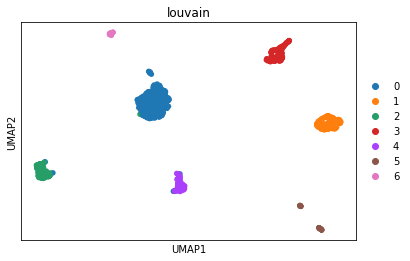

(978,)
For k = 15
The silhouette_score is : 0.3027768
The ari_score is : 0.931588610377629
The v_score is : 0.9121324087615031
Total score is : 0.7154992775487373


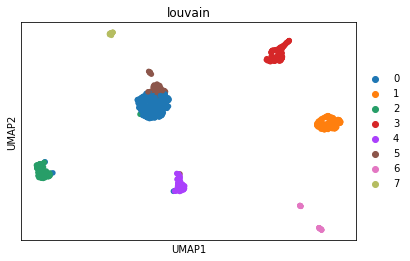

(978,)
For k = 16
The silhouette_score is : 0.27552366
The ari_score is : 0.8095177795266617
The v_score is : 0.8725675569934346
Total score is : 0.6525363330290783


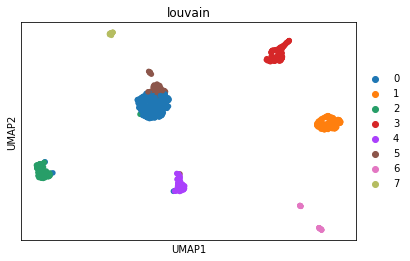

(978,)
For k = 17
The silhouette_score is : 0.27552366
The ari_score is : 0.8095177795266617
The v_score is : 0.8725675569934346
Total score is : 0.6525363330290783


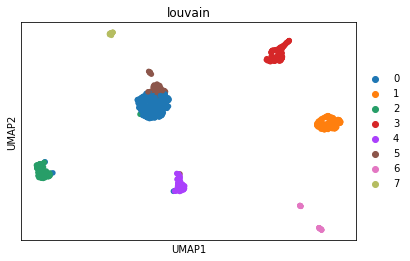

(978,)
For k = 18
The silhouette_score is : 0.27552366
The ari_score is : 0.8095177795266617
The v_score is : 0.8725675569934346
Total score is : 0.6525363330290783


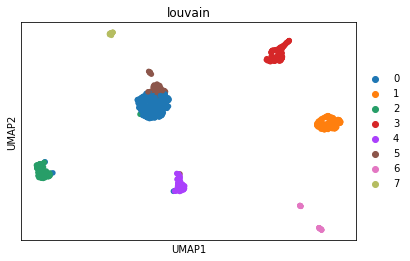

(978,)
For k = 19
The silhouette_score is : 0.27552366
The ari_score is : 0.8095177795266617
The v_score is : 0.8725675569934346
Total score is : 0.6525363330290783


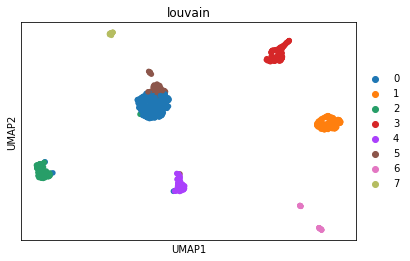

(978,)
For k = 20
The silhouette_score is : 0.27552366
The ari_score is : 0.8095177795266617
The v_score is : 0.8725675569934346
Total score is : 0.6525363330290783


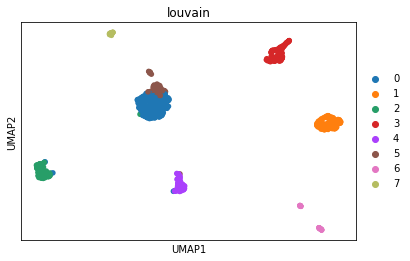

(978,)
For k = 21
The silhouette_score is : 0.2752984
The ari_score is : 0.80606715959284
The v_score is : 0.8717930630812192
Total score is : 0.6510528698287564


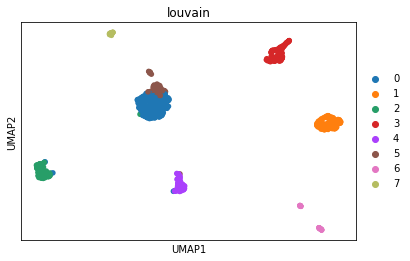

(978,)
For k = 22
The silhouette_score is : 0.2752984
The ari_score is : 0.80606715959284
The v_score is : 0.8717930630812192
Total score is : 0.6510528698287564


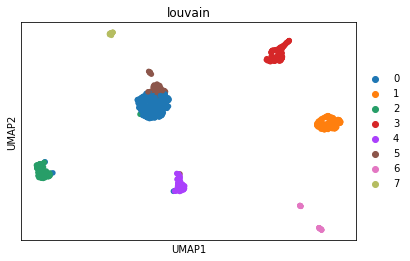

(978,)
For k = 23
The silhouette_score is : 0.27552366
The ari_score is : 0.8095177795266617
The v_score is : 0.8725675569934346
Total score is : 0.6525363330290783


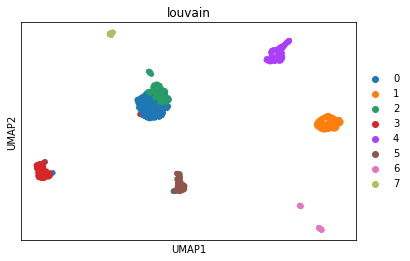

(978,)
For k = 24
The silhouette_score is : 0.25030214
The ari_score is : 0.731798014964036
The v_score is : 0.8549020977285589
Total score is : 0.612334082878987


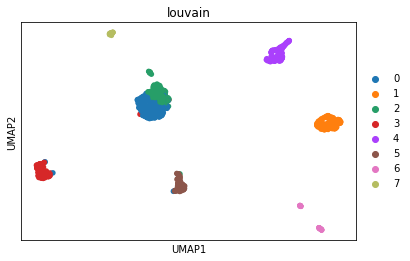

(978,)
For k = 25
The silhouette_score is : 0.24905115
The ari_score is : 0.7288360221562146
The v_score is : 0.8543682277053
Total score is : 0.6107518011737784


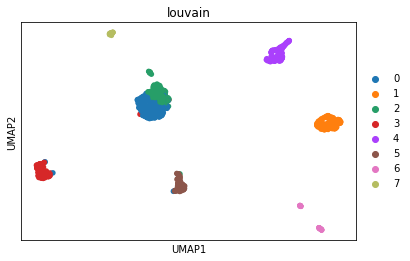

(978,)
For k = 26
The silhouette_score is : 0.24905115
The ari_score is : 0.7288360221562146
The v_score is : 0.8543682277053
Total score is : 0.6107518011737784


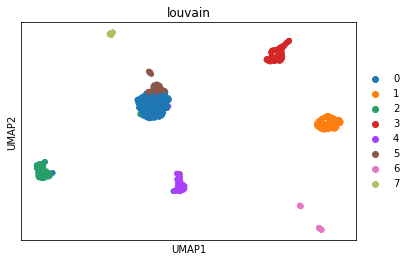

(978,)
For k = 27
The silhouette_score is : 0.2736114
The ari_score is : 0.8015694107624847
The v_score is : 0.8688119461932534
Total score is : 0.6479975845022902


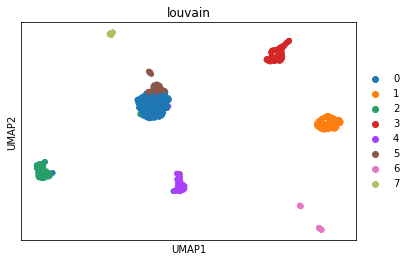

(978,)
For k = 28
The silhouette_score is : 0.2732124
The ari_score is : 0.799877625178633
The v_score is : 0.8684388081366885
Total score is : 0.6471762787914425


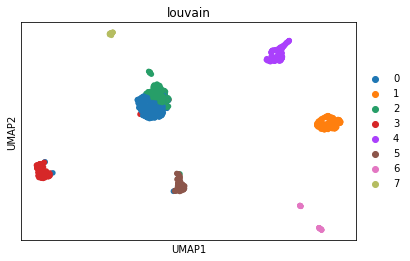

(978,)
For k = 29
The silhouette_score is : 0.24557997
The ari_score is : 0.7175682915112053
The v_score is : 0.852365275102204
Total score is : 0.6051711798255356


In [149]:
for i in range(1, 30):
    sc.tl.leiden(sc_pancreas, key_added="louvain", resolution=i/30, random_state=252)

    sc.pl.umap(
        sc_pancreas,
        color=["louvain"],
        frameon=True,
    )

    labels = (sc_pancreas.obs["louvain"].to_numpy().astype(int) + 1).ravel()
    print(labels.shape)
    silhouette_score = get_silhouette_score(sc_pancreas.obsm["X_hm"], labels)
    ari_score = get_ari_score(sc_pancreas.obs["Celltype"].ravel(), labels)
    v_score = get_v_score(sc_pancreas.obs["Celltype"].ravel(), labels)
    print(
        "For k =",
        i
    )
    print(
        "The silhouette_score is :",
        silhouette_score,
    )
    print(
        "The ari_score is :",
        ari_score,
    )
    print(
        "The v_score is :",
        v_score,
    )
    print(
        "Total score is :",
        (silhouette_score + ari_score + v_score) / 3
    )


/home/philipp/.local/lib/python3.8/site-packages/sklearn/neighbors/_base.py:199: EfficiencyWarning: Precomputed sparse input was not sorted by data.
  warnings.warn(


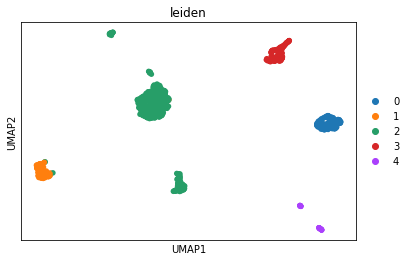

For k = 5
The silhouette_score is : 0.2338613
The ari_score is : 0.6600367905347986
The v_score is : 0.802468504417448
Total score is : 0.56545553077375


/home/philipp/.local/lib/python3.8/site-packages/sklearn/neighbors/_base.py:199: EfficiencyWarning: Precomputed sparse input was not sorted by data.
  warnings.warn(


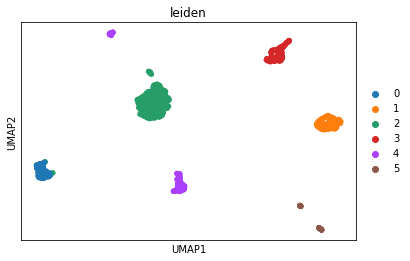

For k = 6
The silhouette_score is : 0.2935073
The ari_score is : 0.9178111602532381
The v_score is : 0.901631910015302
Total score is : 0.7043167926788027


/home/philipp/.local/lib/python3.8/site-packages/sklearn/neighbors/_base.py:199: EfficiencyWarning: Precomputed sparse input was not sorted by data.
  warnings.warn(


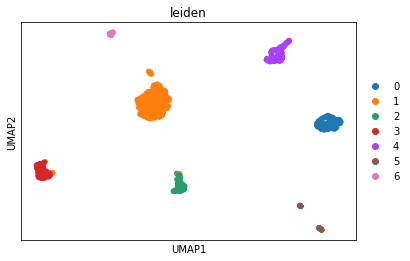

For k = 7
The silhouette_score is : 0.30234745
The ari_score is : 0.930974050629882
The v_score is : 0.9122565553155142
Total score is : 0.7151926857979456


/home/philipp/.local/lib/python3.8/site-packages/sklearn/neighbors/_base.py:199: EfficiencyWarning: Precomputed sparse input was not sorted by data.
  warnings.warn(


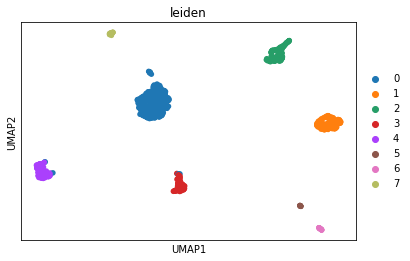

For k = 8
The silhouette_score is : 0.30932882
The ari_score is : 0.9330710451469478
The v_score is : 0.9204113369405488
Total score is : 0.7209370687897297


/home/philipp/.local/lib/python3.8/site-packages/sklearn/neighbors/_base.py:199: EfficiencyWarning: Precomputed sparse input was not sorted by data.
  warnings.warn(


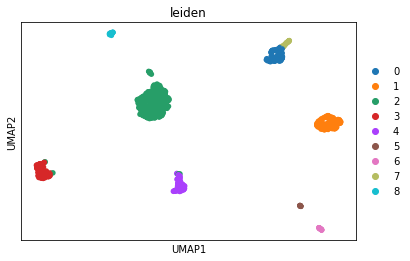

For k = 9
The silhouette_score is : 0.29417628
The ari_score is : 0.9187967158011585
The v_score is : 0.903559764820953
Total score is : 0.7055109203735387


/home/philipp/.local/lib/python3.8/site-packages/sklearn/neighbors/_base.py:199: EfficiencyWarning: Precomputed sparse input was not sorted by data.
  warnings.warn(


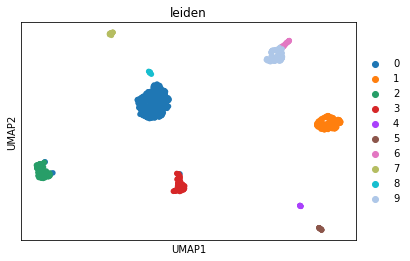

For k = 10
The silhouette_score is : 0.30461392
The ari_score is : 0.9465046748913142
The v_score is : 0.9223421806376431
Total score is : 0.7244869245316607


/home/philipp/.local/lib/python3.8/site-packages/sklearn/neighbors/_base.py:199: EfficiencyWarning: Precomputed sparse input was not sorted by data.
  warnings.warn(


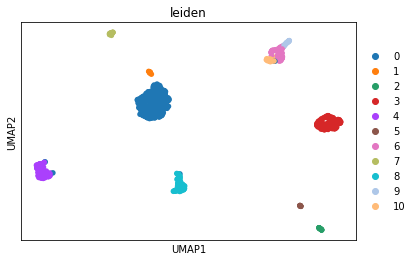

For k = 11
The silhouette_score is : 0.28495747
The ari_score is : 0.9327818516104383
The v_score is : 0.9049779618749129
Total score is : 0.7075724273316751


/home/philipp/.local/lib/python3.8/site-packages/sklearn/neighbors/_base.py:199: EfficiencyWarning: Precomputed sparse input was not sorted by data.
  warnings.warn(


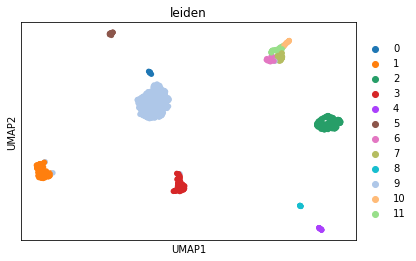

For k = 12
The silhouette_score is : 0.28553194
The ari_score is : 0.9268394649162617
The v_score is : 0.8947585369128389
Total score is : 0.70237664663504


/home/philipp/.local/lib/python3.8/site-packages/sklearn/neighbors/_base.py:199: EfficiencyWarning: Precomputed sparse input was not sorted by data.
  warnings.warn(


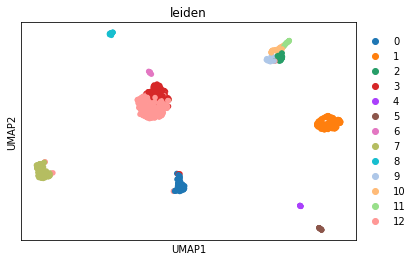

For k = 13
The silhouette_score is : 0.2248829
The ari_score is : 0.7183248442127894
The v_score is : 0.8341359890144165
Total score is : 0.5924479113140267


/home/philipp/.local/lib/python3.8/site-packages/sklearn/neighbors/_base.py:199: EfficiencyWarning: Precomputed sparse input was not sorted by data.
  warnings.warn(


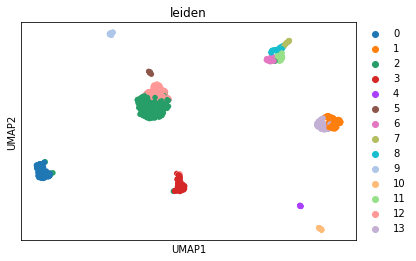

For k = 14
The silhouette_score is : 0.19206685
The ari_score is : 0.6726806466646121
The v_score is : 0.814396293982885
Total score is : 0.5597145963085143


In [153]:
for i in range(5, 15):
    clusterer = SpectralClustering(n_clusters=i, affinity="precomputed_nearest_neighbors")
    cluster_labels = clusterer.fit_predict(sc_pancreas.obsp["distances"])
    sc_pancreas.obs["leiden"] = cluster_labels.astype(str)

    sc.pl.umap(
        sc_pancreas,
        color=["leiden"],
        frameon=True,
    )

    labels = (sc_pancreas.obs["leiden"].to_numpy().astype(int) + 1).ravel()
    silhouette_score = get_silhouette_score(sc_pancreas.obsm["X_hm"], labels)
    ari_score = get_ari_score(sc_pancreas.obs["Celltype"].ravel(), labels)
    v_score = get_v_score(sc_pancreas.obs["Celltype"].ravel(), labels)
    print(
        "For k =",
        i
    )
    print(
        "The silhouette_score is :",
        silhouette_score,
    )
    print(
        "The ari_score is :",
        ari_score,
    )
    print(
        "The v_score is :",
        v_score,
    )
    print(
        "Total score is :",
        (silhouette_score + ari_score + v_score) / 3
    )


# Step 3: Predict on the test data

In [65]:
sc_pancreas_test = sc.AnnData(sc_pancreas_test.T.to_df(), sc_pancreas_metadata_test)

In [66]:
# normalize to depth 10 000
sc.pp.normalize_per_cell(sc_pancreas_test, counts_per_cell_after=1e4)

# logaritmize
sc.pp.log1p(sc_pancreas_test)

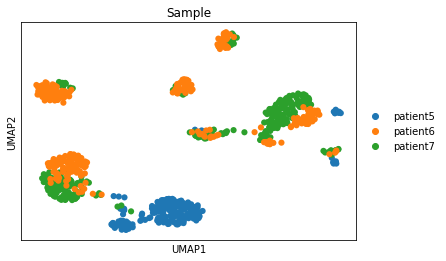

In [67]:
sc.tl.pca(sc_pancreas_test, n_comps=50, svd_solver='arpack')
sc.pp.neighbors(sc_pancreas_test)
sc.tl.umap(sc_pancreas_test)

sc.pl.umap(
    sc_pancreas_test,
    color=["Sample"],
    frameon=True,
)

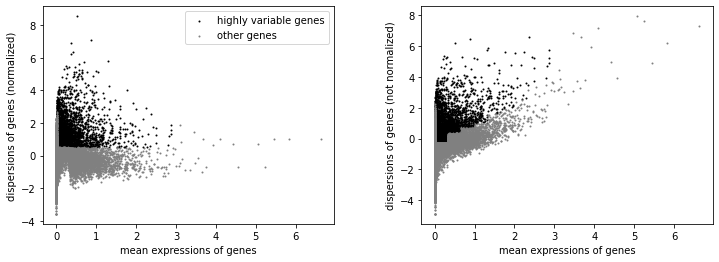

In [68]:
sc.pp.highly_variable_genes(sc_pancreas_test, min_mean=0.0125, max_mean=3, min_disp=0.5)
sc.pl.highly_variable_genes(sc_pancreas_test)

In [69]:
sc.external.pp.harmony_integrate(sc_pancreas_test, key="Sample", adjusted_basis="X_hm", max_iter_harmony=100, sigma=0.1)

2022-05-03 09:26:25,507 - harmonypy - INFO - Iteration 1 of 100
2022-05-03 09:26:25,626 - harmonypy - INFO - Iteration 2 of 100
2022-05-03 09:26:25,681 - harmonypy - INFO - Iteration 3 of 100
2022-05-03 09:26:25,760 - harmonypy - INFO - Iteration 4 of 100
2022-05-03 09:26:25,805 - harmonypy - INFO - Iteration 5 of 100
2022-05-03 09:26:25,835 - harmonypy - INFO - Iteration 6 of 100
2022-05-03 09:26:25,862 - harmonypy - INFO - Iteration 7 of 100
2022-05-03 09:26:25,890 - harmonypy - INFO - Converged after 7 iterations


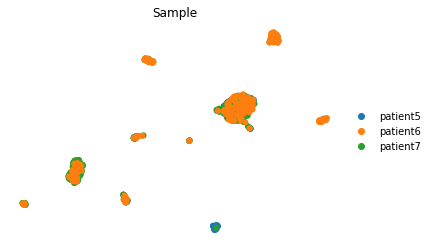

In [70]:
sc.pp.neighbors(sc_pancreas_test, use_rep="X_hm")
sc.tl.umap(sc_pancreas_test, min_dist=0.1)

sc.pl.umap(
    sc_pancreas_test,
    color=["Sample"],
    frameon=False,
)

In [190]:
# sc.tl.leiden(sc_pancreas_test, key_added="leiden", resolution=0.4, random_state=252)
clusterer = SpectralClustering(n_clusters=10, affinity="precomputed_nearest_neighbors")
cluster_labels = clusterer.fit_predict(sc_pancreas_test.obsp["distances"])
sc_pancreas_test.obs["leiden"] = cluster_labels.astype(str)

# sc.pl.umap(
#     sc_pancreas_test,
#     color=["leiden"],
#     frameon=True,
# )

cluster_labels = (sc_pancreas_test.obs["leiden"].to_numpy().astype(int) + 1).ravel()
print(get_silhouette_score(sc_pancreas_test.obsm["X_hm"], cluster_labels))

0.4153293


/home/philipp/.local/lib/python3.8/site-packages/sklearn/neighbors/_base.py:199: EfficiencyWarning: Precomputed sparse input was not sorted by data.
  warnings.warn(


/home/philipp/.local/lib/python3.8/site-packages/sklearn/neighbors/_base.py:199: EfficiencyWarning: Precomputed sparse input was not sorted by data.
  warnings.warn(


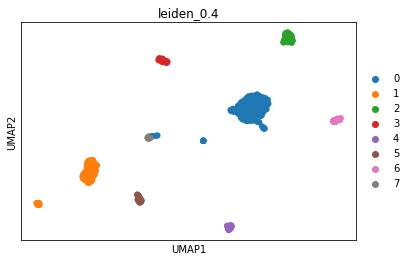

For k = 9
The silhouette_score is : 0.39085326


In [231]:
#for i in range(5, 15):
clusterer = SpectralClustering(n_clusters=8, affinity="precomputed_nearest_neighbors")
cluster_labels = clusterer.fit_predict(sc_pancreas_test.obsp["distances"])
sc_pancreas_test.obs["leiden_0.4"] = cluster_labels.astype(str)

sc.pl.umap(
    sc_pancreas_test,
    color=["leiden_0.4"],
    frameon=True,
)

labels = (sc_pancreas_test.obs["leiden_0.4"].to_numpy().astype(int) + 1).ravel()
silhouette_score = get_silhouette_score(sc_pancreas_test.obsm["X_hm"], labels)
    # ari_score = get_ari_score(sc_pancreas.obs["Celltype"].ravel(), labels)
    # v_score = get_v_score(sc_pancreas.obs["Celltype"].ravel(), labels)
print(
    "For k =",
    9
)
print(
    "The silhouette_score is :",
    silhouette_score,
)
    # print(
    #     "The ari_score is :",
    #     ari_score,
    # )
    # print(
    #     "The v_score is :",
    #     v_score,
    # )
    # print(
    #     "Total score is :",
    #     (silhouette_score + ari_score + v_score) / 3
    # )


In [198]:
# cluster_labels = sc_pancreas_test.obs["pheno_louvain"].to_numpy() + 1
cluster_labels = pd.DataFrame(cluster_labels.reshape((-1, 1)), range(0, len(cluster_labels)))
cluster_labels.columns = ["cluster"]
cluster_labels.insert(0, "index", sc_pancreas_test.to_df().index)
cluster_labels.set_index("index")
print(cluster_labels)

            index  cluster
0    patient5_A12        7
1    patient5_A14        1
2    patient5_A20        1
3    patient5_A22        1
4     patient5_A4        1
..            ...      ...
784  patient6_P22        0
785  patient6_P23        6
786   patient6_P4        4
787   patient6_P7        4
788   patient6_P9        4

[789 rows x 2 columns]


In [107]:
PCA = sc_pancreas_test.obsm["X_hm"]
PCA = pd.DataFrame(PCA)
PCA.columns = [("PC" + str(i)) for i in range(1, 51)]
PCA.insert(0, "index", sc_pancreas_test.to_df().index)
PCA.set_index("index")
print(PCA)

            index        PC1        PC2        PC3       PC4        PC5  \
0    patient5_A12  -9.980407  -0.331167  11.672299 -2.194221  11.285526   
1    patient5_A14 -13.838789  -6.190482  -3.990319  1.696537   1.613109   
2    patient5_A20 -11.201538  -3.389529  -2.296270 -0.076659  -5.932941   
3    patient5_A22  -8.136659  -2.831779  -2.397397  2.136900  -3.966069   
4     patient5_A4 -12.389326  -3.959414  -5.575157  1.394415  -0.575270   
..            ...        ...        ...        ...       ...        ...   
784  patient6_P22  -6.765347   9.288177   0.637208 -1.535840   6.362998   
785  patient6_P23  -6.371626   7.247236  -5.038999  0.093957   0.947438   
786   patient6_P4  -3.259581  21.188517   4.201673 -3.293536  -1.047552   
787   patient6_P7  -3.664094  19.808874   5.917020 -1.749286   0.938351   
788   patient6_P9  -4.058885  20.339466   4.733729 -2.986892   0.659151   

           PC6       PC7       PC8        PC9  ...      PC41      PC42  \
0     0.824251 -1.600086 

# Step 4: Save the required files

In [54]:
# bulkified should be a DataFrame containing the "bulkified" version of the imputed data
# bulkified.columns = ["patient5","patient6","patient7"]
# bulkified.index = sc_pancreas_test.index

In [108]:
results_path = "results"
archive_name = "Biohackers_Project2.zip" # TODO

In [109]:
assert all(bulkified.columns == ["index","patient5","patient6","patient7"])

In [110]:
assert all(bulkified["index"] == sc_pancreas_test.to_df().T.index)

In [111]:
bulkified

,index,patient5,patient6,patient7
0,SGIP1,136.723854,659.433086,186.120736
1,AZIN2,621.530976,661.248850,315.562388
2,CLIC4,980.767113,3776.468248,4257.269531
3,AGBL4,190.960494,387.494271,141.951960
4,NECAP2,1140.123651,4453.838727,3256.290553
...,...,...,...,...
25448,KIR2DL5B,0.000397,0.000000,0.000234
25449,KIR2DS2,0.000397,0.000000,0.000234
25450,KIR2DS1,0.000397,0.000000,0.000234
25451,KIR2DL2,0.000397,0.000000,0.000234


In [ ]:
# cluster_labels should be a DataFrame containing the cluster labels for each cell
# cluster_labels["index"] = sc_pancreas_test.columns
# cluster_labels.columns = ["index", "cluster"]
# cluster_labels["index"] = sc_pancreas_test.columns

In [112]:
assert all(cluster_labels.columns == ["index","cluster"])

In [113]:
assert all(cluster_labels["index"] == sc_pancreas_test.to_df().T.columns)

In [114]:
cluster_labels

,index,cluster
0,patient5_A12,6
1,patient5_A14,0
2,patient5_A20,0
3,patient5_A22,0
4,patient5_A4,0
...,...,...
784,patient6_P22,4
785,patient6_P23,2
786,patient6_P4,3
787,patient6_P7,3


In [61]:
# PCA should be a DataFrame containing the coordinates of each cell in the PCA transformed space for the 50 first PCs
# PCA.columns = ["index", "PC1", "PC2", ..., "PC50"]
# PCA["index"] = sc_pancreas_test.columns

In [115]:
assert all(PCA.columns == ["index"] + ["PC"+str(i+1) for i in range(50)])

In [116]:
assert all(PCA["index"] == sc_pancreas_test.to_df().T.columns)
# print(sc_pancreas_test.to_df().columns)

In [118]:
with zipfile.ZipFile(os.path.join(results_path, archive_name), "x") as zf:
    with zf.open(f"imputed_bulkified.csv", "w") as buffer:
        bulkified.to_csv(buffer)
    with zf.open(f"cluster_membership.csv", "w") as buffer:
        cluster_labels.to_csv(buffer)
    with zf.open(f"PCA.csv", "w") as buffer:
        PCA.to_csv(buffer)
    zf.close()

In [119]:
archive = zipfile.ZipFile(os.path.join(results_path, archive_name))
assert all(
        [
            i in archive.namelist()
            for i in [
                "imputed_bulkified.csv",
                "cluster_membership.csv",
                "PCA.csv",
            ]
        ]
    )